In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np 
import torchvision.utils as utils
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import os


In [3]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

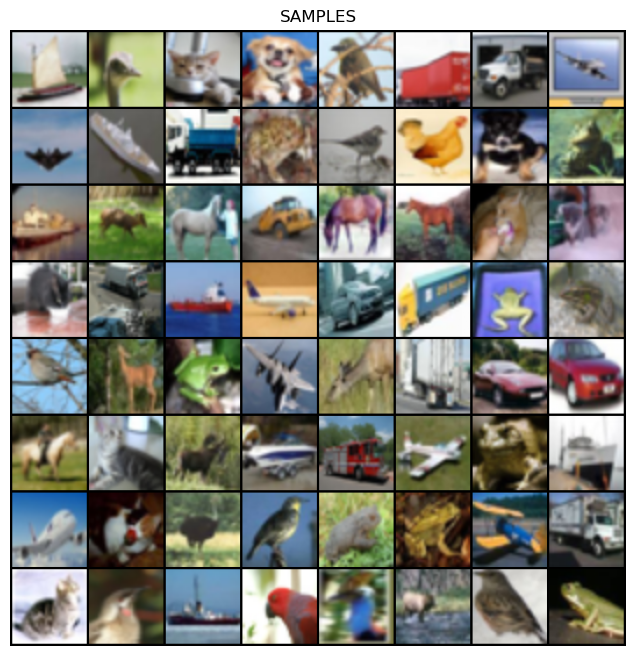

In [5]:
transform_pipeline = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR10 dataset
cifar_data = datasets.CIFAR10(
    root="./dataset/CIFAR10data", 
    download=True,
    transform=transform_pipeline
)

# Create a DataLoader for batching and shuffling
data_loader = torch.utils.data.DataLoader(
    cifar_data, 
    batch_size=64,
    shuffle=True
)
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("SAMPLES")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [6]:


class Discriminator(nn.Module):
    def __init__(self, in_channels, base_features):
        super(Discriminator, self).__init__()
        
        # Define the sequential layers for the discriminator
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, base_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            self._block(base_features, base_features * 2, 4, 2, 1),    # First block
            self._block(base_features * 2, base_features * 4, 4, 2, 1),  # Second block
            self._block(base_features * 4, base_features * 8, 4, 2, 1),  # Third block
            
            nn.Conv2d(base_features * 8, 1, kernel_size=4, stride=2, padding=0)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.model(x)


class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, base_features):
        super(Generator, self).__init__()

        # Define the sequential layers for the generator
        self.model = nn.Sequential(
            self._block(latent_dim, base_features * 8, 4, 1, 0),  # First block
            self._block(base_features * 8, base_features * 4, 4, 2, 1),  # Second block
            self._block(base_features * 4, base_features * 2, 4, 2, 1),  # Third block
            self._block(base_features * 2, base_features, 4, 2, 1),  # Fourth block
            
            nn.ConvTranspose2d(base_features, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output range [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)
BATCH_SIZE = 32


In [8]:

def init_weights(model):
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data, mean=0.0, std=0.02)

# Gradient Penalty function (WGAN-GP)
def gradient_penalty(critic, real_images, fake_images, device):
    batch_size, channels, height, width = real_images.shape
    
    # Generate random interpolation factor (alpha) between 0 and 1
    alpha = torch.rand((batch_size, 1, 1, 1), device=device).repeat(1, channels, height, width)
    
    # Create interpolated images
    interpolated_images = real_images * alpha + fake_images * (1 - alpha)
    
    # Compute critic scores for interpolated images
    interpolated_scores = critic(interpolated_images)
    
    # Compute gradients of the scores with respect to the interpolated images
    gradients = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=interpolated_scores,
        grad_outputs=torch.ones_like(interpolated_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Flatten gradients and compute their L2 norm
    gradients = gradients.view(gradients.size(0), -1)
    gradients_l2_norm = gradients.norm(2, dim=1)
    
    # Compute the gradient penalty
    gradient_penalty_value = torch.mean((gradients_l2_norm - 1) ** 2)
    
    return gradient_penalty_value


In [9]:
import torch
import torch.optim as optim
import torch.nn as nn

# Hyperparameters
discriminator_features = 64
generator_features = 64
image_channels = 3  # RGB images
noise_dim = 100  # Dimension of the input noise vector
learning_rate = 6e-5  # Learning rate for both optimizers
BATCH_SIZE = 64  # Batch size (you can adjust this based on available GPU memory)

# Check for GPU availability, else default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Initialize the Generator and Discriminator models
generator = Generator(noise_dim, image_channels, generator_features).to(device)
discriminator = Discriminator(image_channels, discriminator_features).to(device)

# Weight initialization function
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data, mean=0.0, std=0.02)

# Weight initialization for both models
initialize_weights(generator)
initialize_weights(discriminator)

# Optimizers for the Generator and Discriminator
optimizer_gen = optim.RMSprop(generator.parameters(), lr=learning_rate)
optimizer_disc = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

# Fixed noise for monitoring the generator's output during training
fixed_noise = torch.randn(BATCH_SIZE, noise_dim, 1, 1).to(device)


# Step counter to track training iterations
step = 0

# Example: Training loop (simplified for testing)
# This is just a basic skeleton to get you started with running the code

# Dummy training loop to test if everything works
num_epochs = 1  # Set a small number of epochs for testing purposes
for epoch in range(num_epochs):
    for i in range(100):  # Simulate 100 batches per epoch
        # Here you'd normally load a batch of real images from your dataset.
        # For testing, we'll generate random "real" images.
        real_images = torch.randn(BATCH_SIZE, image_channels, 64, 64).to(device)  # Dummy real images
        fake_images = generator(fixed_noise)  # Generate fake images from noise

        # Train the Discriminator
        optimizer_disc.zero_grad()

        # Calculate discriminator loss for real and fake images
        real_scores = discriminator(real_images)
        fake_scores = discriminator(fake_images.detach())  # Detach to avoid backprop through generator

        # Calculate loss (e.g., for WGAN-GP, use binary cross-entropy or Wasserstein loss)
        d_loss_real = torch.mean(real_scores)
        d_loss_fake = torch.mean(fake_scores)

        # Gradient Penalty (WGAN-GP)
        gp = gradient_penalty(discriminator, real_images, fake_images, device)

        # Total discriminator loss
        d_loss = d_loss_fake - d_loss_real + gp
        d_loss.backward(retain_graph=True)  # Retain the graph for the generator backward pass
        optimizer_disc.step()

        # Train the Generator
        optimizer_gen.zero_grad()

        # Generator's goal is to fool the discriminator
        g_loss = -torch.mean(discriminator(fake_images))
        g_loss.backward()  # Now we can safely call backward because the graph is retained
        optimizer_gen.step()

        # Output training stats every few steps
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/100], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, gradient_penalty: {gp.item():.4f}")

    # Example: Save generated images or monitor progress (optional)
    # fake_images = generator(fixed_noise)
    # save_image(fake_images, f"generated_images_epoch_{epoch+1}.png")


In [10]:
generator.train(),discriminator.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTr

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import models

class InceptionV3(nn.Module):
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling features
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True, normalize_input=True, requires_grad=False):
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, 'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        # Load pre-trained Inception V3 model
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        # Resize and normalize input if needed
        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        # Pass through blocks
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)
            if idx == self.last_needed_block:
                break

        return outp

# Function to calculate activation statistics
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    activations = np.empty((len(images), dims))
    
    # Move images to GPU if needed
    batch = images.cuda() if cuda else images
    pred = model(batch)[0]  # Get output from model's first output block

    # Ensure the output has a size of (1, 1)
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

    # Flatten activations to 2D
    activations = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    # Calculate mean and covariance
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    
    return mu, sigma

# Function to approximate square root matrix (sqrtm)
def sqrtm_approx(A, method='ss'):
    if method == 'ss':
        # Scaling and squaring method
        U, s, V = np.linalg.svd(A)
        s = np.diag(np.sqrt(s))
        return U.dot(s).dot(V)
    elif method == 'pi':
        # Power iteration method
        maxiter = 100
        tol = 1e-6
        X = np.eye(A.shape[0])
        for i in range(maxiter):
            Y = 0.5 * (X + A.dot(np.linalg.inv(X)))
            if np.max(np.abs(X - Y)) < tol:
                break
            X = Y
        return X
    else:
        raise ValueError("Invalid method: %s" % method)

# Function to calculate Frechet Inception Distance (FID)
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1, mu2 = np.atleast_1d(mu1), np.atleast_1d(mu2)
    sigma1, sigma2 = np.atleast_2d(sigma1), np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Covariance matrices have different dimensions'
    
    # Compute difference of means
    diff = mu1 - mu2
    
    # Compute covariance matrix
    covmean = sqrtm_approx(sigma1.dot(sigma2), 'ss')

    # Handle numerical errors (non-finite covariance matrix)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm_approx((sigma1 + offset).dot(sigma2 + offset))

    # Make sure covariance matrix is real
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError(f'Imaginary component: {m}')
        covmean = covmean.real

    # Compute FID score
    tr_covmean = np.trace(covmean)
    fid_score = (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

    return fid_score

# Function to calculate FID between real and fake images
def calculate_fretchet(images_real, images_fake, model):
    mu_real, sigma_real = calculate_activation_statistics(images_real, model, cuda=True)
    mu_fake, sigma_fake = calculate_activation_statistics(images_fake, model, cuda=True)
    fid_value = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
    return fid_value


/home/sbhavan/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sbhavan/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0
FID_list = []
GP_weight = 10
criticItr = 5
MAX_EPOCHS = 40
Noise_input = 100 
optimGenerator = optim.RMSprop(generator.parameters(), lr=6e-5)
optimDiscriminator = optim.RMSprop(discriminator.parameters(), lr=6e-5)
model = InceptionV3([InceptionV3.BLOCK_INDEX_BY_DIM[2048]]).to(device)

# Main training loop
# Assuming 'device' is already defined (either 'cuda' or 'cpu')

# Main training loop
for epoch in range(1, MAX_EPOCHS + 1):  # Starting from 1 to match epoch output
    for batch_idx, data in enumerate(data_loader, 0):
        real = data[0].to(device)
        batch_size = real.shape[0]  # Size of the current batch
        
        # Training the Critic multiple times (criticItr)
        for _ in range(criticItr):
            noise = torch.randn(batch_size, Noise_input, 1, 1).to(device)
            fake = generator(noise)  # Generate fake images
            
            critic_real = discriminator(real).reshape(-1)
            critic_fake = discriminator(fake).reshape(-1)
            
            # Compute Gradient Penalty
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            gp = gradient_penalty(discriminator, real, fake, device)  # Pass 'device' here
            
            # Critic loss with gradient penalty
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + (GP_weight * gp)
            
            discriminator.zero_grad()  # Zero the discriminator gradients
            loss_critic.backward(retain_graph=True)  # Backpropagate critic loss
            optimDiscriminator.step()  # Update discriminator

        # Generator loss and optimization step
        output = discriminator(fake).reshape(-1)
        loss_gen = -torch.mean(output)  # Minimize discriminator output on fake images
        generator.zero_grad()  # Zero the generator gradients
        loss_gen.backward()  # Backpropagate generator loss
        optimGenerator.step()  # Update generator

        # Store the losses for later visualization or analysis
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())

        # Save generated images and calculate FID score at intervals
        if iters % 500 == 0 or (epoch == MAX_EPOCHS and batch_idx == len(data_loader) - 1):
            with torch.no_grad():
                fake_images = generator(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake_images, padding=2, normalize=True))
        
        iters += 1  # Increment iteration counter
        
    # Calculate FID (Frechet Inception Distance) score
    fid_score = calculate_fretchet(real, fake, model)
    FID_list.append(fid_score)
    
    # Print training statistics at each epoch
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{MAX_EPOCHS}] Batch {batch_idx}/{len(data_loader)} "
              f"Discriminator Loss: {loss_critic:.3f}, Generator Loss: {loss_gen:.3f}, FID Score: {fid_score:.3f}")

# Generate some sample images after training
labels = torch.arange(0, 10, dtype=torch.long, device=device)
noise = torch.randn(10, Noise_input, device=device)  
generated_images = generator(noise)  # Generate images based on noise


Epoch  [5/40] Batch 781/782 \discriminator loss -20.174, generator loss 118.455, FID Score: 364.269 
Epoch  [10/40] Batch 781/782 \discriminator loss -20.627, generator loss 151.713, FID Score: 351.594 
Epoch  [15/40] Batch 781/782 \discriminator loss -35.796, generator loss 162.688, FID Score: 356.919 
Epoch  [20/40] Batch 781/782 \discriminator loss -15.470, generator loss 185.953, FID Score: 354.147 
Epoch  [25/40] Batch 781/782 \discriminator loss -21.158, generator loss 210.627, FID Score: 342.761 
Epoch  [30/40] Batch 781/782 \discriminator loss -20.924, generator loss 235.643, FID Score: 327.563 
Epoch  [35/40] Batch 781/782 \discriminator loss -25.622, generator loss 247.204, FID Score: 336.083 
Epoch  [40/40] Batch 781/782 \discriminator loss -21.965, generator loss 280.618, FID Score: 326.984 


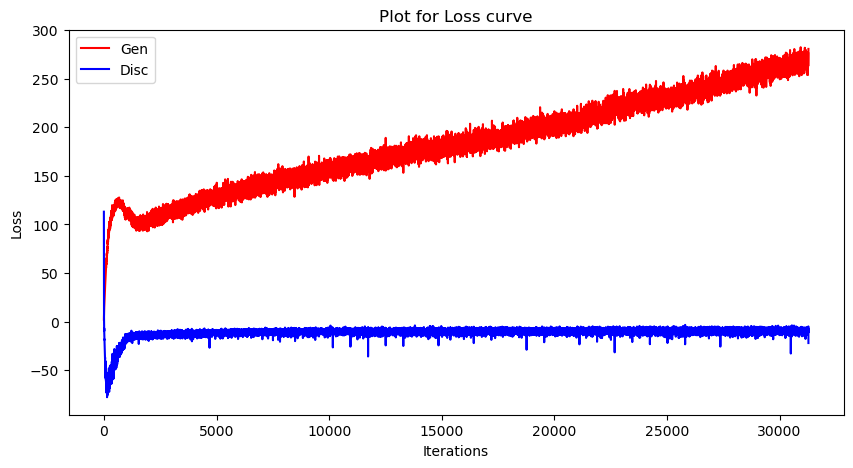

In [14]:
plt.figure(figsize=(10,5))
plt.title("Plot for Loss curve")
plt.plot(GenLoss, label="Gen", color="red")
plt.plot(DiscLoss, label="Disc", color="blue")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


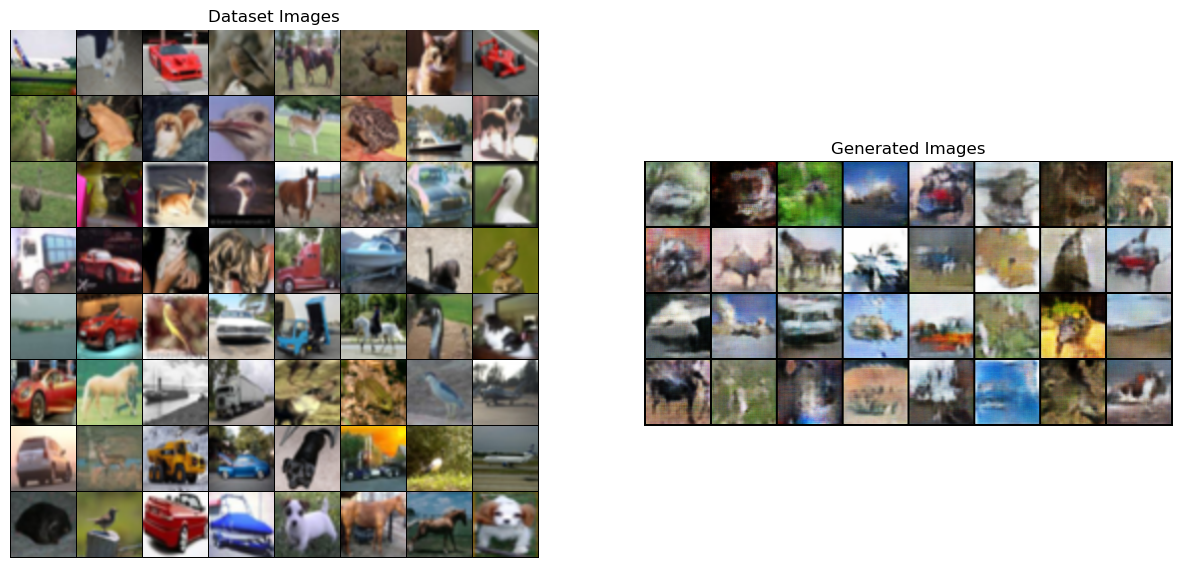

In [15]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Dataset Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

plt.show()

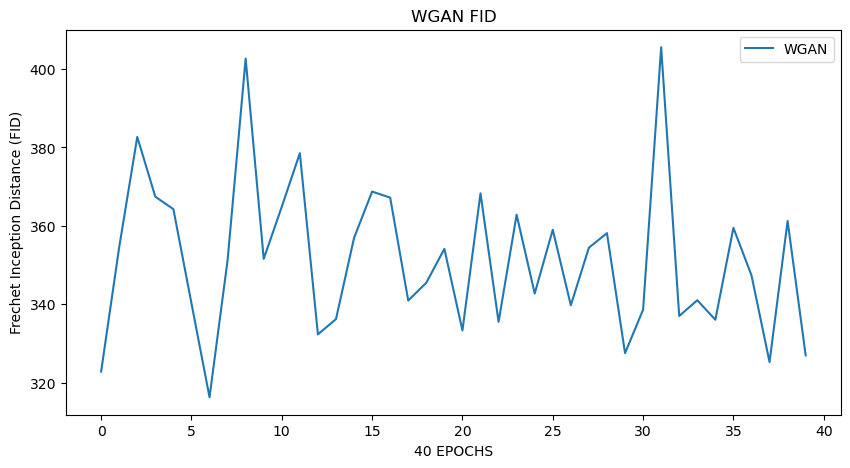

In [16]:
plt.figure(figsize=(10,5))
plt.title("WGAN FID")
plt.plot(FID_list,label="WGAN")
plt.xlabel("40 EPOCHS")
plt.ylabel("Frechet Inception Distance (FID)")
plt.legend()
plt.show()

